In [ ]:
jupyter-nbconvert --to slides "PuPPy - Pokemon Go KDTree.ipynb" --reveal-prefix=reveal.js --post serve

# Using KDTrees to calculate distances
## Or: the best coffee shop in Hong Kong for Pokemon

Michael Patterson

I work with spatial data, we use KDTrees all the time. Never heard of it before, so thought I'd present it.

Premise: you're a Pokemon Go player, and want to know the best place to catch Pokemon. For example, maybe you want to drink coffee, surf the internet and catch them.

In [1]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

# How can I find the closest coffee shop to each Pokemon in a city?
## The brute force method:
Calculate the distance between every pair of locations

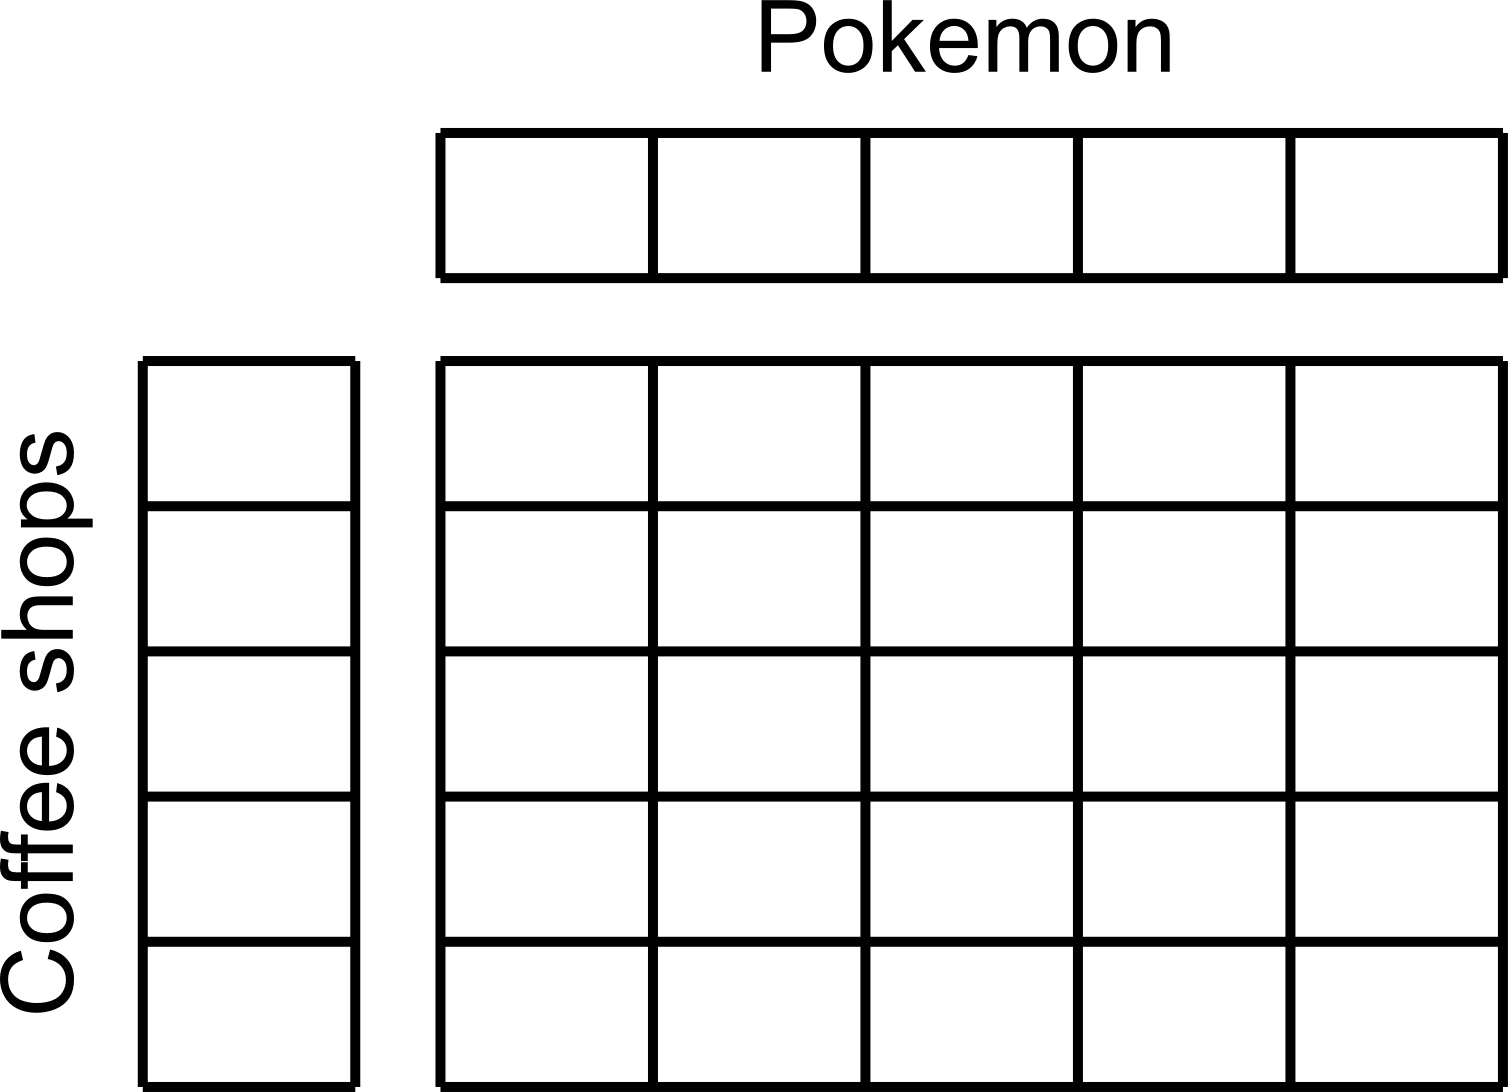

In [2]:
Image(filename= 'Distance grid.png', width=600) 

$Time\ complexity = P_{pokemon} * C_{coffee shops} \approx O(n^2)$

## KDTrees are much faster

$Time\ complexity = P_{pokemon} * log(C_{coffee shops}) \approx O(n\ log(n))$

## KDTrees are just multidimensional Binary Search Trees
For geographic information, this means the binary search tree alternates latitude (North / South) and longitude (East / West).

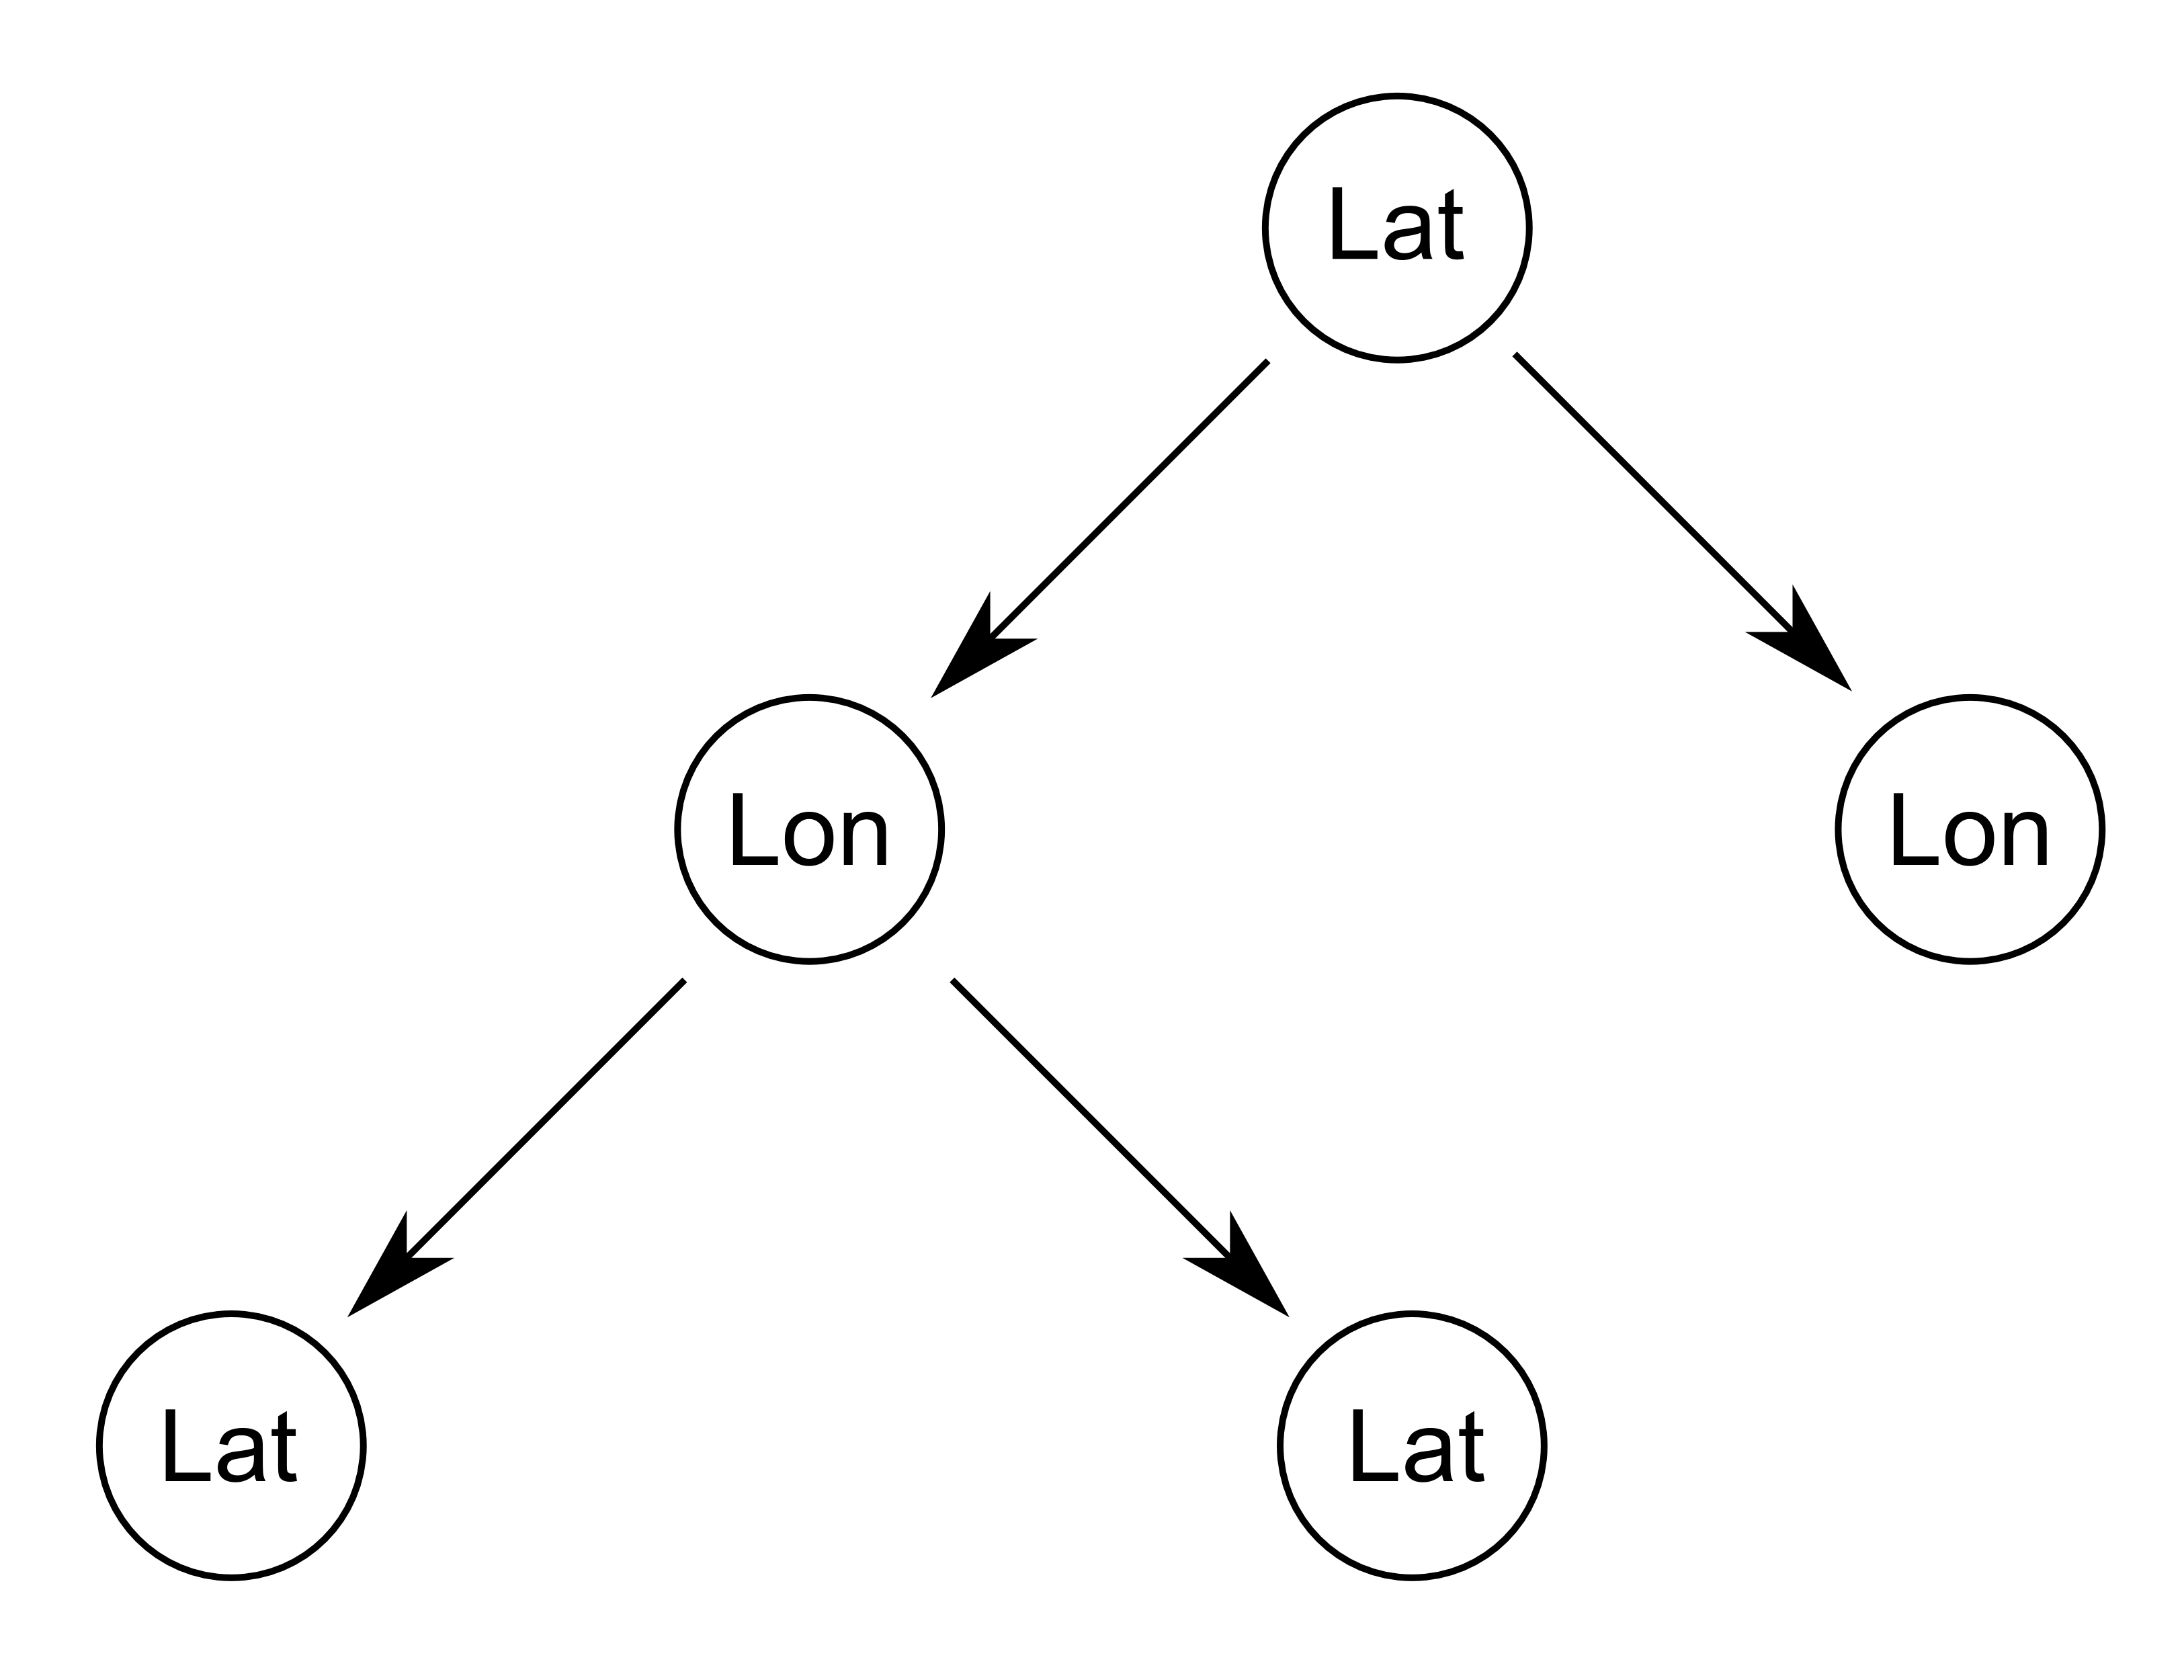

In [3]:
Image(filename= 'Full Tree.png', width=600) 

# Example of how a KDTree would find the closest coffee shop to a Pokemon

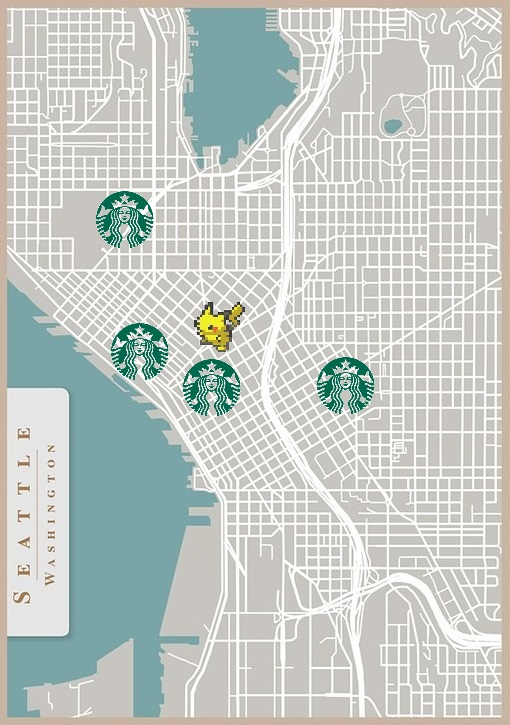

In [8]:
# map taken from delovelyArts on Etsy
Image(filename= 'Seattle.jpg', width=600) 

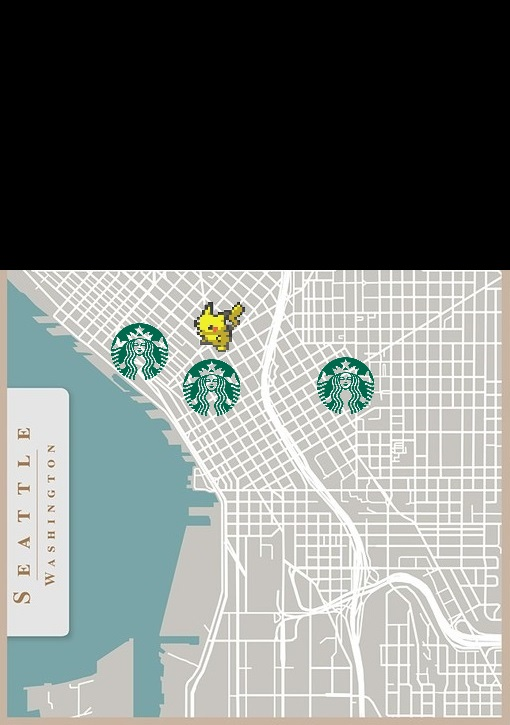

In [9]:
Image(filename= 'Seattle-2.jpg', width=600) 

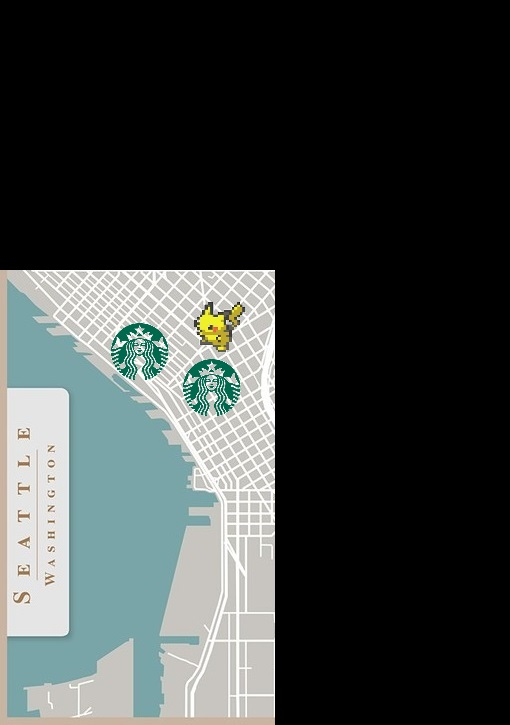

In [10]:
Image(filename= 'Seattle-3.jpg', width=600) 

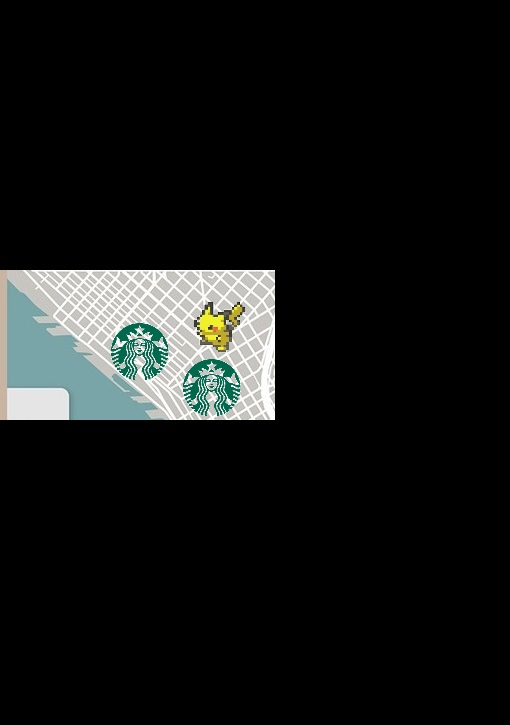

In [11]:
Image(filename= 'Seattle-4.jpg', width=600) 

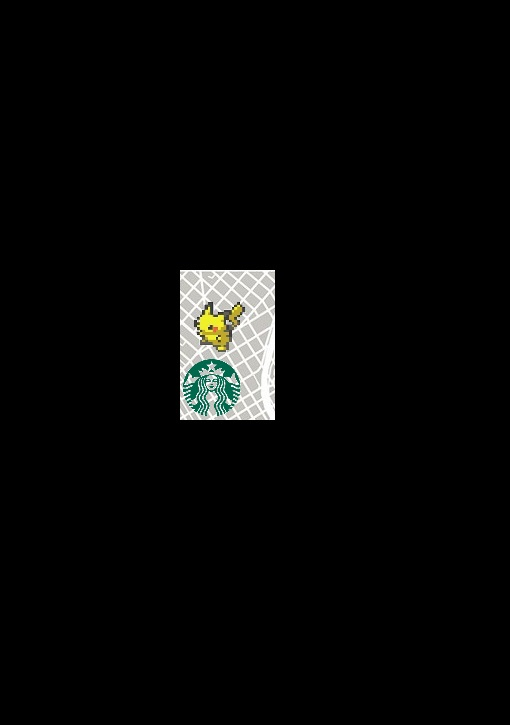

In [13]:
Image(filename= 'Seattle-5.jpg', width=600) 

# Practical example: finding the coffee shop in Hong Kong with the most Pokemon nearby

## Why Hong Kong?

Niantic (Nintendo) doesn't make is easy to scrape Pokemon data.

Nintendo is constantly changing the encryption and API calls, as well as shutting down bot accounts. I tried downloading the data using hacked APIs, but could never get it to work.

### Downloaded location data from http://pokemon.appx.hk

Manually scraped location data from .xhr files, and pasted into JSONs.

## What does the Pokemon data look like?

In [2]:
def load_poke_json( pokefile):
    return pd.read_json( pokefile ).rename(columns={'a':'lat', 'i':'type', 't':'ts', 'o':'lon'})
hk_poke_json = glob.glob('data/hk-*.json')
hk_poke_df = pd.concat( [load_poke_json(x) for x in  hk_poke_json ] )

In [3]:
# hk_poke_df is a pandas dataframe
hk_poke_df[['lat', 'lon', 'type']].head()

lat         lon  type
0  22.208449  114.031100     8
1  22.223130  114.120200    56
2  22.248989  113.944586    74
3  22.254273  113.863911    35
4  22.444772  114.050984    84

In [96]:
hk_poke_df['lat'].count()

18732

In [12]:
hk_poke_df.type.value_counts().head()

35     2823
79     1361
102     925
27      846
42      843
Name: type, dtype: int64

In [5]:
(hk_poke_df.type.value_counts() < 10).sum()

32

In [ ]:
map.readshapefile('DC_2015_poly_Shapefile/GIH3_DC_2015_POLY', 'district', default_encoding='windows-1252')
patches = []
for info, shape in zip(map.coast_info, map.coast ):
    if info['NATURAL'] == 'shoreline':
        patches.append( Polygon(np.array(shape), True))

ax.add_collection(PatchCollection(patches, facecolor= 'm', edgecolor='k', linewidths=1., zorder=2))

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

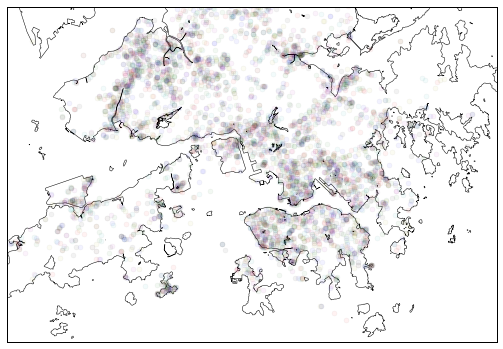

In [37]:
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(1,figsize = (12,6))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.15,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong')
map.readshapefile('shapefiles/hong_kong_coastline', 'coast')
for index, pokemon in hk_poke_df.head(5000).iterrows():
    map.plot(pokemon['lon'],pokemon['lat'] , latlon=True, marker = 'o', markersize = 5, alpha = 0.05)
plt.show()

# Downloaded coffee shop locations from Foursquare
Searched for coffe shops using a grid of latitude / longitude coordinates

In [38]:
hk_coffee_df = pd.io.json.json_normalize( json.loads(open('hk_coffee.json').read() ) )[['location.lat', 'location.lng', 'name']]
hk_coffee_df.head(3)

location.lat  location.lng                 name
0     22.308377    113.918438            Starbucks
1     22.311764    113.917056       Pacific Coffee
2     22.227676    113.932410  Baby's Coffee Store

In [14]:
hk_coffee_df.name.count()

586

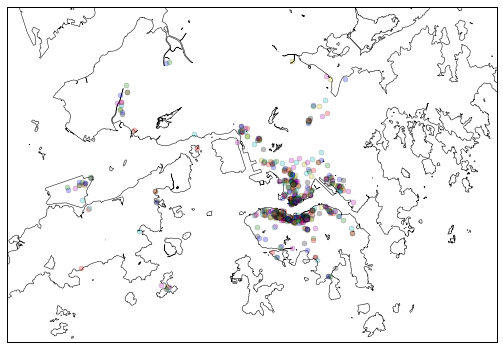

In [44]:
fig, ax = plt.subplots(1,figsize = (12,6))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.15,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong')
map.readshapefile('shapefiles/hong_kong_coastline', 'coast')
for index, coffee_shop in hk_coffee_df.iterrows():
    map.plot(coffee_shop['location.lng'],coffee_shop['location.lat'],
             latlon=True, marker = 'o', markersize = 5, alpha = 0.25)
plt.show()

# Let's calculate some distances!
First, let's try the brute force algorithm

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

In [105]:
%%timeit
distances = euclidean_distances(hk_coffee_df[['location.lat', 'location.lng']],
                                hk_poke_df[['lat', 'lon']])

1 loop, best of 3: 338 ms per loop


In [107]:
hk_coffee_df['brute_force_pokemon'] = map(lambda x: np.sum( x < 0.0005 ), distances )
hk_coffee_df.query('brute_force_pokemon > 5')

location.lat  location.lng                    name  brute_force_pokemon
40      22.207968    114.029331         Coffee Seeds 阿翁                    6
64      22.270550    114.130811  Pacific Coffee (太平洋咖啡)                    6
333     22.318484    114.174676               Starbucks                    7

# Let's see how fast KDTrees are

In [41]:
from scipy.spatial import cKDTree
coffee_kdtree = cKDTree( hk_coffee_df[['location.lat', 'location.lng']] )

In [104]:
%%timeit
# .query() is how you pass locations into a KDTree
radius = 0.0005 # the pokemon should be within ~50 meters of a coffee shop
kdtree_counts = coffee_kdtree.query( hk_poke_df[['lat', 'lon']],
                                    k=10, # return a maximum of 10  shops
                                    distance_upper_bound=radius )

100 loops, best of 3: 10.6 ms per loop


In [108]:
hk_coffee_df['kdtree_pokemon'] = pd.Series( kdtree_counts[1].ravel() ).value_counts()
hk_coffee_df = hk_coffee_df.fillna(0)
hk_coffee_df.query('kdtree_pokemon > 5')

location.lat  location.lng                    name  brute_force_pokemon  \
40      22.207968    114.029331         Coffee Seeds 阿翁                    6   
64      22.270550    114.130811  Pacific Coffee (太平洋咖啡)                    6   
333     22.318484    114.174676               Starbucks                    7   

     kdtree_pokemon  
40              6.0  
64              6.0  
333             7.0

# Where is the best coffee shop?
# INSERT MAP HERE

## KDTrees are an easy, fast way to calculate nearest neighbors
## Go to XYZ coffee shop to catch Pokemon

# Go catch some Pokemon!
https://github.com/map222/trailofpapers/tree/master/pokemon

@trailofpapers

www.trailofpapers.net

### Further notes on complexity
$Build\ complexity = O(n\ log(n) )$

$Search\ complexity = O( log(n) )$


# KDTree Diagram

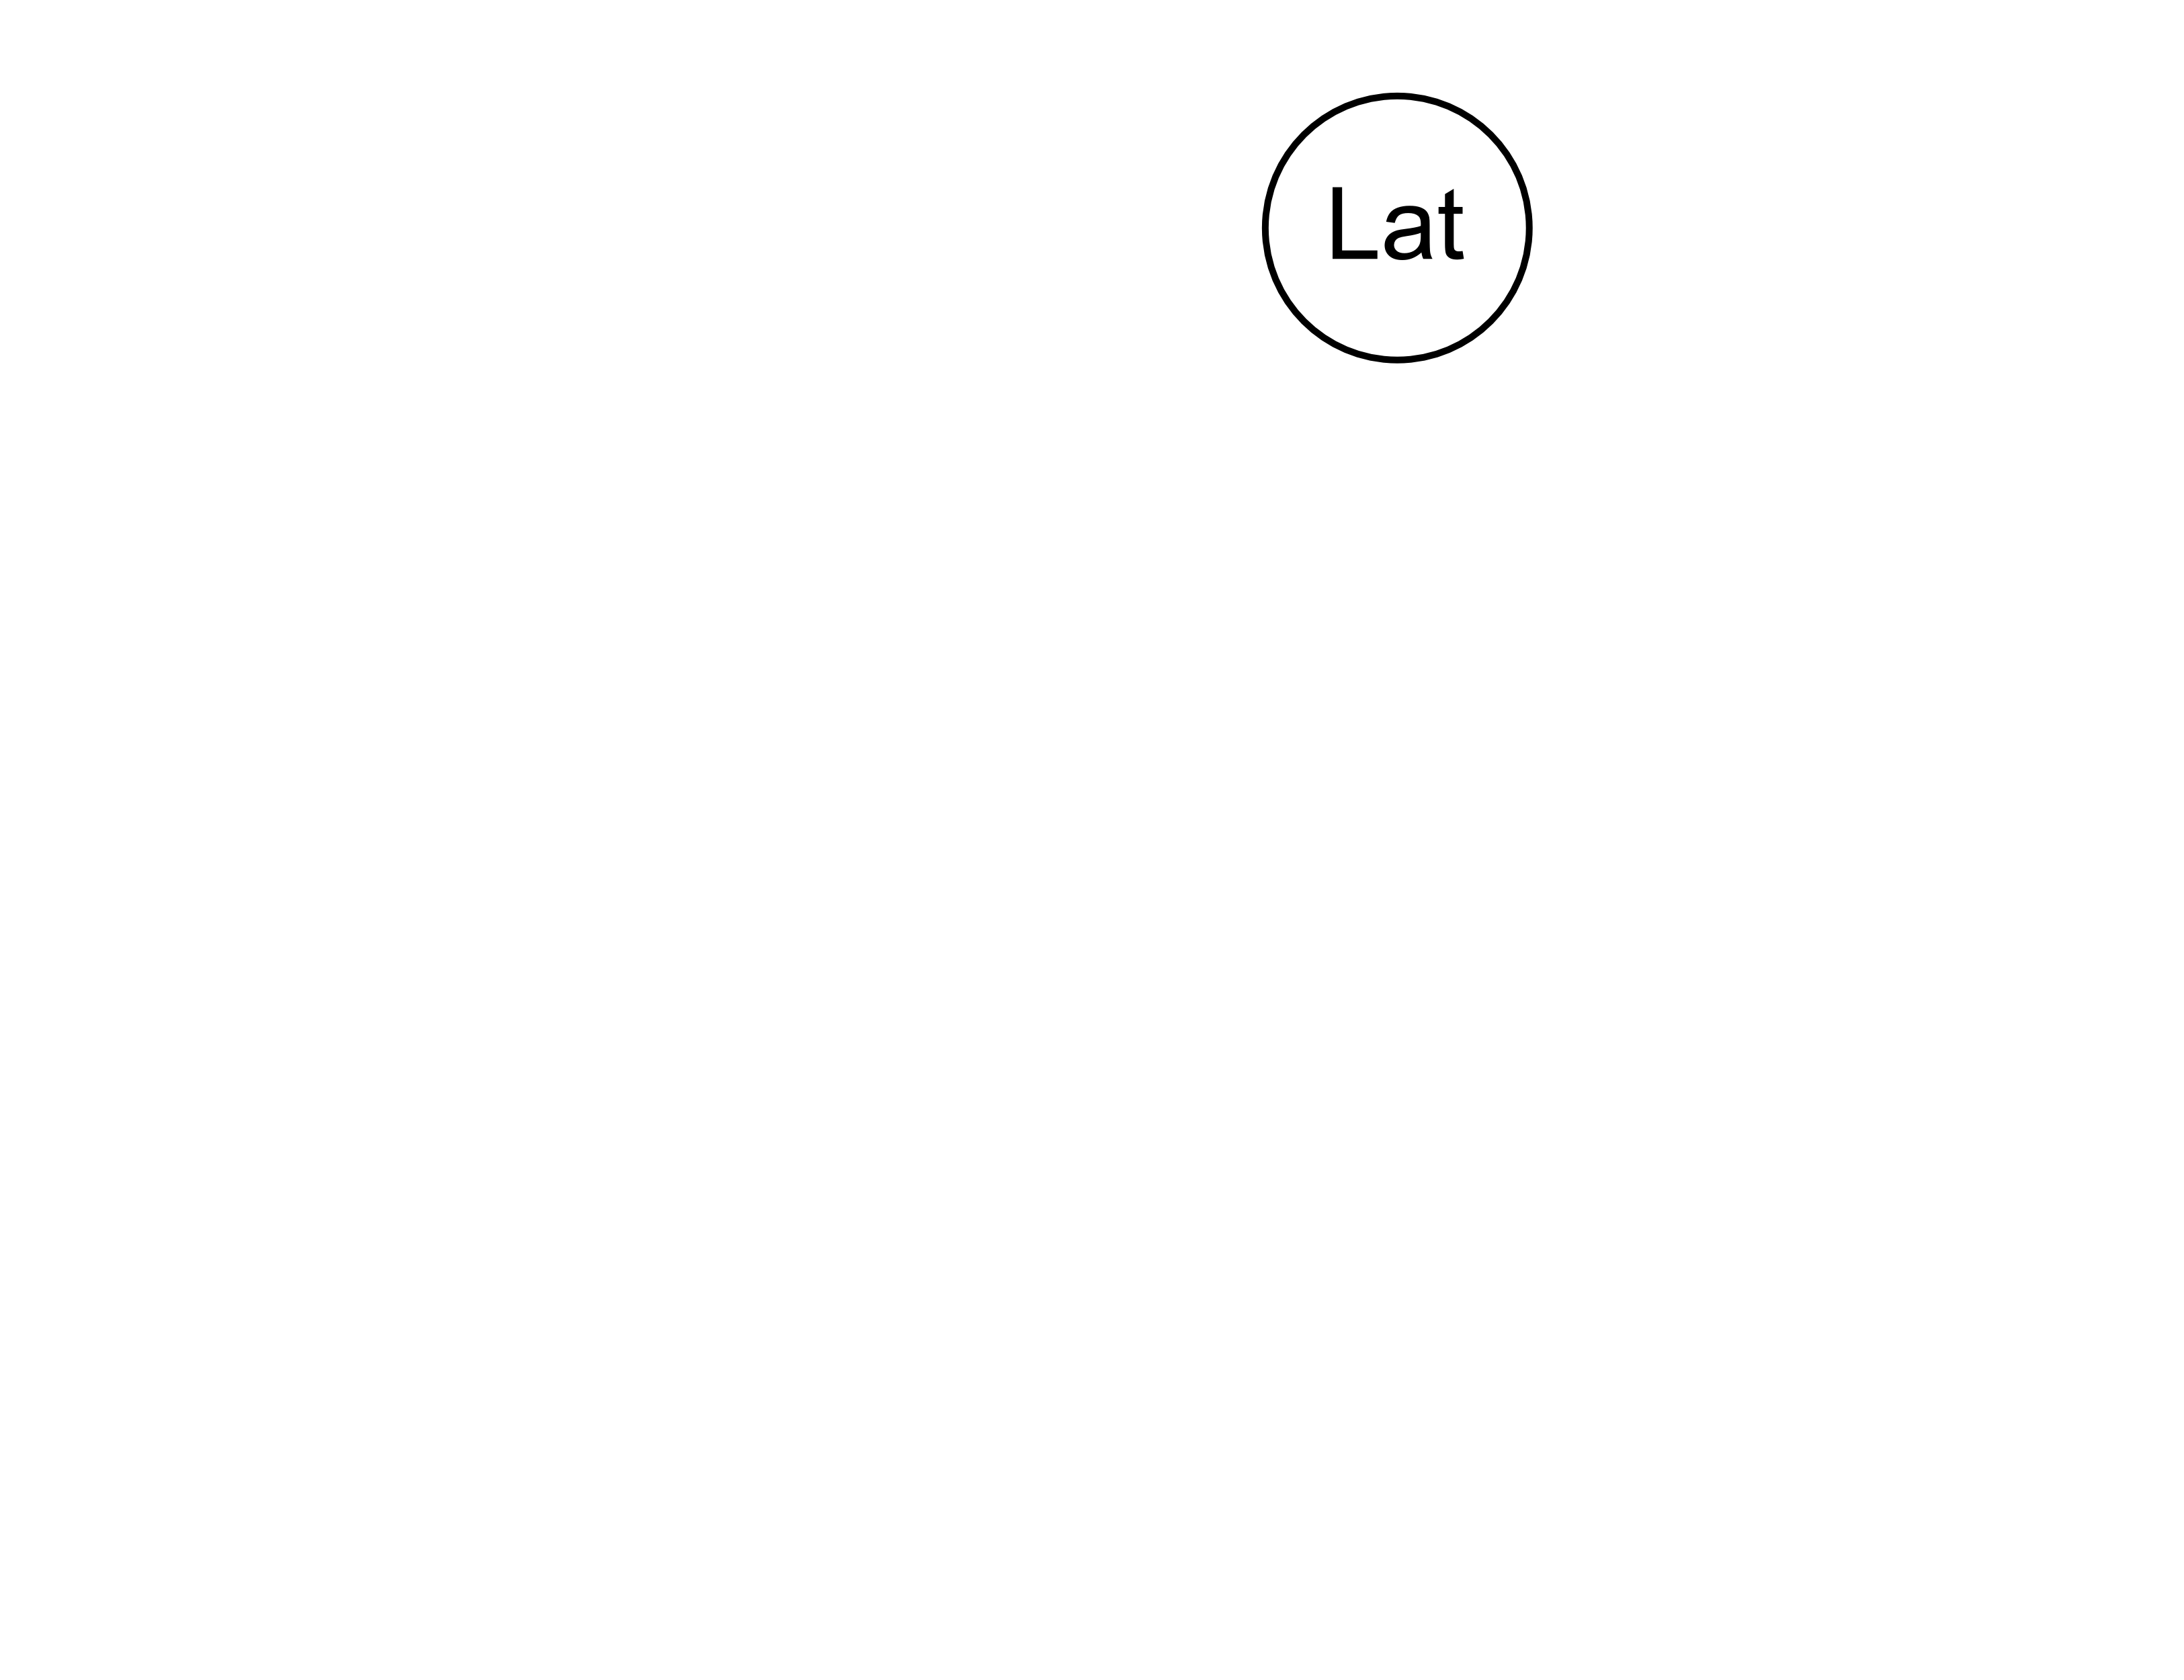

In [6]:
Image(filename= 'Root Tree.png', width=600) 

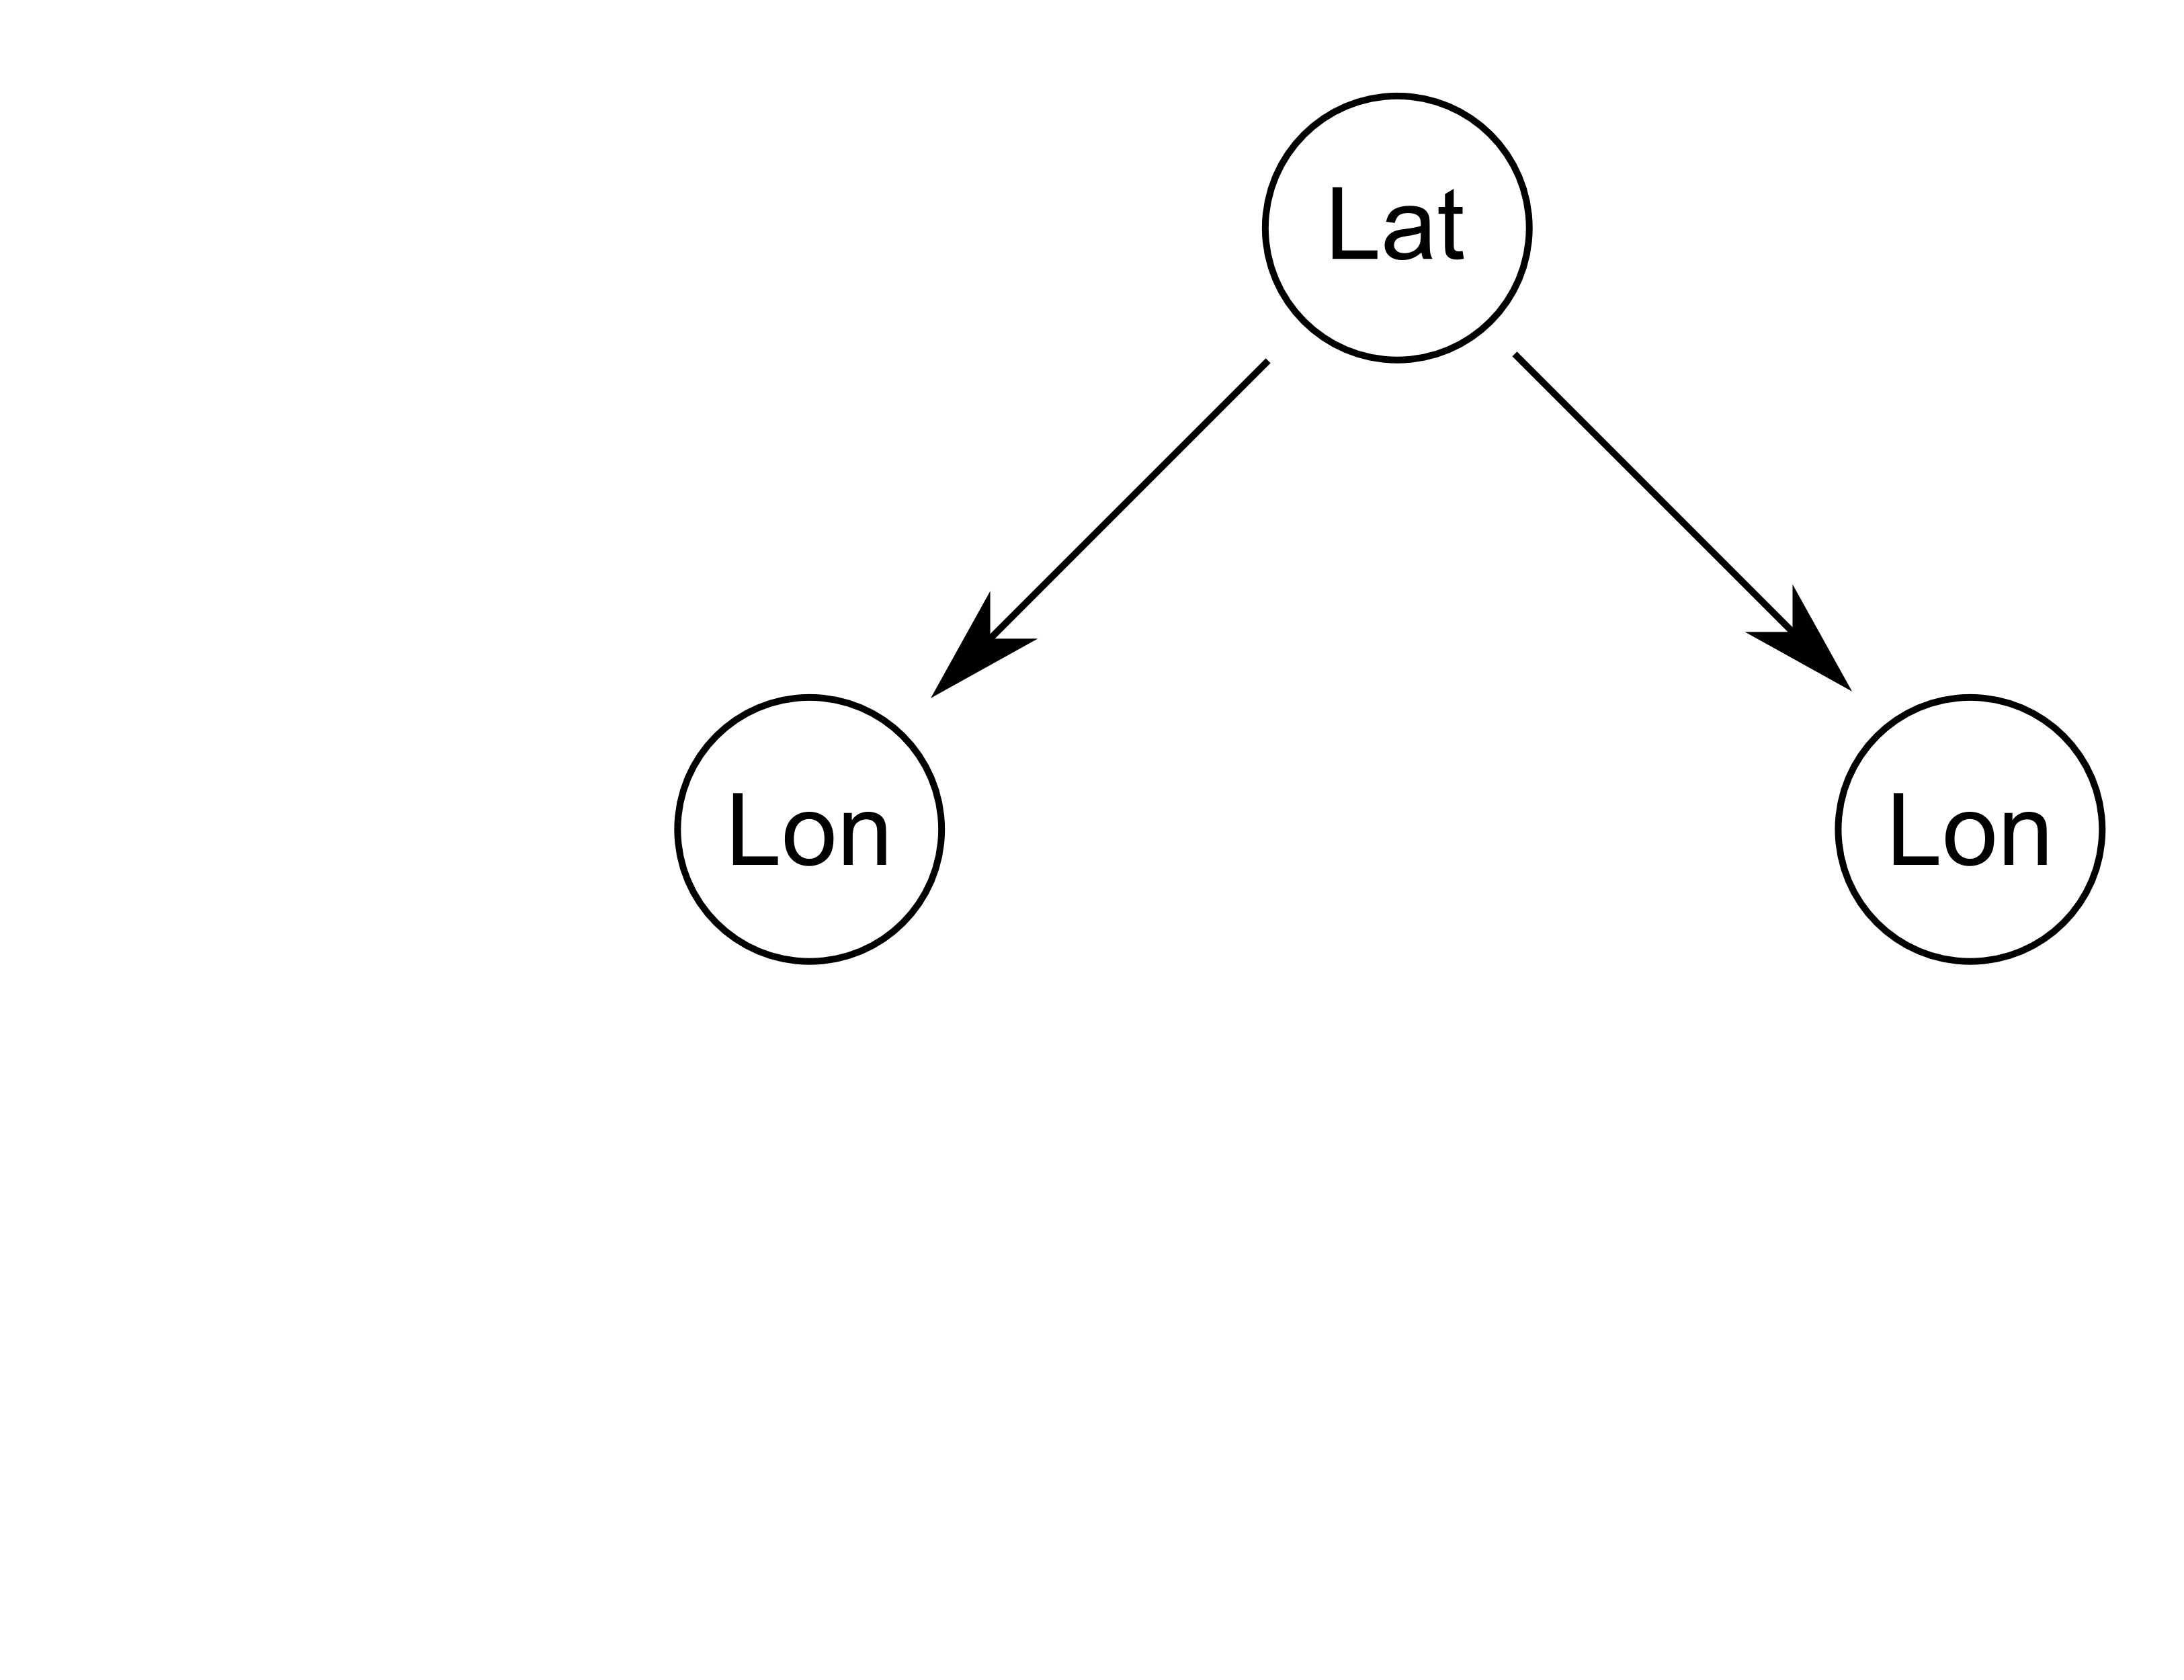

In [7]:
Image(filename= 'Half Tree.png', width=600) 

The distribution of pokemon is highly skewed, with two types of Pokemon making up >30% of the total. Around 20% of Pokemon are so rare, they seen < 10 times.

Now that we have a single dataset, we can save it as a csv to load into PySpark. (You can actually load the data directly using `spark.create.DataFrame()`, but wanted to save the intermediate dataset so people don't have to remake it.)

<a id='kdtree'></a>
# Querying KDTrees in Spark
Now that we have our Pokemon and coffee shop data processed, we can load the data into Spark! First, we can start by broadcasting the coffee_kdtree to all of the executors.

In [9]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
coffee_tree_broadcast = sc.broadcast( coffee_kdtree )

Next, we need to load the pokemon data into Spark. Here I define a simple schema using StructType, then load the pokemon csv using `spark.read.csv`, and finally `persist` the dataframe.

In [10]:
poke_schema = T.StructType([
                T.StructField('lat', T.FloatType(), False),
                T.StructField('lon', T.FloatType(), False),
                T.StructField('ts', T.FloatType(), False),
                T.StructField('type', T.IntegerType(), False)
                ])
poke_df = spark.read.csv('hk_pokemon.csv', schema = poke_schema).persist()

Finally, we need to make a function to query the KDTree. The function takes two columns from the DataFrame, and passes them through the KDTree one at a time.

In [11]:
def query_kdtree( lat, lon, cur_tree, radius = 0.0005):
    ''' query the kdtree to find locations within a radius of the lat / lon
        lat / lon: native python floats representing location
        cur_tree: a broadcast scipy cKDTree
        radius: radius, in degrees, around the pokemon to accept pokestops (default to ~50m)
    '''
    
    # a standard scipy cKDTree query, we want up to 10 coffeehouses within the radius of each pokemon
    query_results = cur_tree.value.query([lat, lon], 10, distance_upper_bound=radius)
    
    # query_results is a list of two arrays (radius, and index); we want to return the index
    # the index is a numpy integer which we needs to be cast as a python integer to return to Spark
    return [int(row[1]) for row in zip(*query_results) if row[0] < radius]

Since we are working in PySpark, we need to wrap the above function in a udf wrapper (user-defined function). The udf will be passed two columns, but we also need to set the KDTree as an argument. Here I use the `partial` function to pass `coffee_tree_broadcast`. You should also be able to use a `lambda` function to similar effect. Udf's require you to specify the return type. In this case, we are returning a list of integers, which are indices in the KDTree.

In [13]:
from functools import partial
coffee_udf = F.udf( partial(query_kdtree, cur_tree = coffee_tree_broadcast),
                    T.ArrayType( T.IntegerType() ) )

We're ready to pass the pokemon through the KDTree! To do so, we just need to add a column to the DataFrame using `withColumn`, applying the `coffee_udf`. Note that we can pass the lat and lon columns simply by naming them. After creating the new column, I use an `explode` statement to separate each shop into its own row. This should make the dataset tidier\*, as each row will represent one pokemon-shop combination.  Notice that after the explosion, the bottom two rows represent a single pokemon, and the two coffee shops it was near.

\*I think that's what tidy means.

In [13]:
nearby_df = (poke_df.withColumn('nearby_shops', coffee_udf('lat', 'lon'))
                    .select('*', F.explode('nearby_shops').alias('shop_index') ).persist() )
nearby_df.show(6)

+---------+---------+------------+----+------------+----------+
|      lat|      lon|          ts|type|nearby_shops|shop_index|
+---------+---------+------------+----+------------+----------+
|22.308178|113.91828|1.48331162E9|  27|         [0]|         0|
|22.207895|114.02905|1.48331187E9|  17|        [40]|        40|
|22.320929|113.94459|1.48331226E9|  56|        [17]|        17|
|22.205046|114.02998|1.48331162E9|  74|        [38]|        38|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        92|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        96|
+---------+---------+------------+----+------------+----------+
only showing top 6 rows



With this data we can answer some simple questions. For example, how many pokemon had a coffee shop nearby?

In [14]:
nearby_df.select('lat', 'lon', 'ts', 'type').distinct().count()

285

Or we can ask how many shops had at least one Pokemon nearby.

In [15]:
(nearby_df.select('shop_index').distinct().count() )

240

Finally, we can answer the question, which are the best coffee shops to catch pokemon? To do that, we can groupby store_index, and then aggregate by count. For display, we want to sort using `orderBy`.

In [16]:
(nearby_df.groupby('shop_index')
          .agg(F.count('shop_index').alias('num_pokemon'))
          .orderBy('num_pokemon', ascending = False).show(5) )

+----------+-----------+
|shop_index|num_pokemon|
+----------+-----------+
|        40|          6|
|        64|          5|
|       333|          5|
|       295|          5|
|       168|          5|
+----------+-----------+
only showing top 5 rows



To see which shops these are, we can go back to the original coffeshop dataframe.

In [17]:
hk_coffee_df.loc[[40, 64, 333, 295, 168]]

location.lat  location.lng                    name
40      22.207968    114.029331         Coffee Seeds 阿翁
64      22.270550    114.130811  Pacific Coffee (太平洋咖啡)
333     22.318484    114.174676               Starbucks
295     22.296741    114.169362               Starbucks
168     22.283222    114.159201               Starbucks

It turns out the best place is a [local place on a tiny southern island](https://foursquare.com/v/coffee-seeds-%E9%98%BF%E7%BF%81/4f547dbfe4b0bf6b5f624b57/)!

In [18]:
hk_coffee_df.name.str.startswith('Starbucks').sum()

150

For kicks, we can also see how many were Starbucks. 150 out of 580! This probably reflects the limitations of our original dataset, as we scraped the coffee shop locations using Four Square. If anyone has a better coffee shop list, let me know!

<a id='rdd'></a>
# Performance of DataFrames vs RDDs
If you go to any Spark workshop or meetup, you will inevitably be told that DataFrames are a lot faster and easier to work with than RDDs. While this dataset is a probably too small for a proper investigation, I thought I'd run some benchmarks to see. To start with, let's see how fast the query is using DataFrames.

In [14]:
%time (poke_df.repartition(1).withColumn('nearby_shops', coffee_udf('lat', 'lon')).count() )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.68 s


16565

1.7 seconds for our 16,000 locations using DataFrames. For RDDs, we can write a similar function, and `map` it.

In [15]:
def query_kdtree_rdd( row, map_tree, radius = 0.0005):
    # first we need to convert the row to a dictionary
    cur_row = row.asDict()
    
    # pass the dictionary through the KDTree
    query_results = map_tree.value.query([row['lat'], row['lon']], 10, distance_upper_bound=radius)
    
    # then convert the results back into a dictionary / row
    cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
    return Row(**cur_row)

In [16]:
%time poke_df.rdd.map(partial(query_kdtree_rdd, map_tree = coffee_tree_broadcast)).count()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.62 s


16565

Only a little bit slower! What if we use `mapPartitions`, which processes an entire partition in one go?

In [17]:
# naive mapPartitions
def query_kdtree_mappartitions(iterator):
    radius = 0.0005
    new_rows = []
    for row in iterator:
        cur_row = row.asDict()
        query_results = coffee_tree_broadcast.value.query([cur_row['lat'], cur_row['lon']], 10, radius)
        cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
        new_rows.append(Row(**cur_row))
    return new_rows

In [18]:
%time poke_df.rdd.mapPartitions(query_kdtree_mappartitions).count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.09 s


16565

30% faster! In previous KDTree benchmarks I've tried, the DataFrame method is ~2x faster than the mapPartitions method. My guess is that this dataset is small enough that the advantages of DataFrames can't shine through. 


## Conclusion
Anyway, this is one way to use KDTrees in PySpark! Some of the key general concepts for me were:
1. Learning how to define `UDF`s on multiple columns of data
2. Figuring out how to pass the KDTree to the function using `partial`
3. Being careful to return native python types, and using the right DataTypes
    
Good Pokehunting and tree searching!